# Data Project: Analyse Employment Shares in Regions in Denmark 

Firstly we import the relevant packages

In [ ]:
import pandas as pd
import pydst
dst = pydst.Dst(lang='en')

#Show all columns in iPython console regardless of amount.
pd.set_option("display.max_columns", None)

We import the table RAS201 from Statistics Denmark - All variables in the table are imported to get the full data set. 


In [ ]:
Emp = dst.get_data(table_id = 'RAS201', variables={'OMRÅDE':['*'], 'TID':['*'], 'ALDER':['*'], 'HERKOMST':['*'], 'KØN':['*'], 'SOCIO': ['*']})

We delete the columns Age, Gender and Ancestry since we are not interested in these. 
Furthermore we rename the remaining variables.

In [ ]:
for v in ['ALDER', 'KØN', 'HERKOMST']: 
    del Emp[v]
Emp = Emp.rename(columns = {'TID':'Year', 'OMRÅDE': 'Region', 'SOCIO': 'Status', 'INDHOLD': 'Num_pers'})

We would like to aggregate the data such that we have it on region pr. year pr. social economical status

We use a Regex code to remove variables that does not contain 'Region' or 'All Denmark'. 

In [ ]:
I = Emp['Region'].str.contains(r'^(?:(?!Region|All Denmark).)*$') 
Emp.drop(Emp[I].index, inplace=True)    

Delete people that are not in labour force

In [ ]:
Outside_LF=Emp['Status']!='Outside the labour force'
LF=Emp[Outside_LF]

Aggregate data to region per year for different socio economical statuses. 

In [49]:
Agg_Emp=LF.groupby(['Region', 'Year', 'Status'])['Num_pers'].sum().reset_index()

Agg_Emp.head()

,Region,Year,Status,Num_pers
0,All Denmark,2008,Employed,2844814
1,All Denmark,2008,Unemployed,64209
2,All Denmark,2009,Employed,2725724
3,All Denmark,2009,Unemployed,130058
4,All Denmark,2010,Employed,2704542


Create new table with new column containing total number of persons in region 

In [51]:
TOT=Agg_Emp.groupby(['Region', 'Year'])['Num_pers'].sum()
TOT.head()

Region       Year
All Denmark  2008    2909023
             2009    2855782
             2010    2836600
             2011    2824217
             2012    2820038
Name: Num_pers, dtype: int64

Create new table with sum of employees in each region

In [52]:
Status_Emp = Agg_Emp['Status']=='Employed'

Agg_Emp_New=Agg_Emp[Status_Emp]

TOT_Emp=Agg_Emp_New.groupby(['Region', 'Year']).sum()

Join the two tables together 

In [54]:
JoinTotal = pd.merge(TOT_Emp.reset_index(),TOT.reset_index(),how='inner',on=['Region','Year'])
JoinTotal.head()

,Region,Year,Num_pers_x,Num_pers_y
0,All Denmark,2008,2844814,2909023
1,All Denmark,2009,2725724,2855782
2,All Denmark,2010,2704542,2836600
3,All Denmark,2011,2698418,2824217
4,All Denmark,2012,2684840,2820038


rename columns

In [55]:
JoinTotal = JoinTotal.rename(columns = {'Num_pers_x':'Employed', 'Num_pers_y':'Population'})

Calculate Employment Share

In [56]:
JoinTotal['Employ_share'] = JoinTotal.Employed/JoinTotal.Population*100

Create Line chart

Region
All Denmark           AxesSubplot(0.125,0.125;0.775x0.755)
Region Hovedstaden    AxesSubplot(0.125,0.125;0.775x0.755)
Region Midtjylland    AxesSubplot(0.125,0.125;0.775x0.755)
Region Nordjylland    AxesSubplot(0.125,0.125;0.775x0.755)
Region Sjælland       AxesSubplot(0.125,0.125;0.775x0.755)
Region Syddanmark     AxesSubplot(0.125,0.125;0.775x0.755)
Name: Employ_share, dtype: object

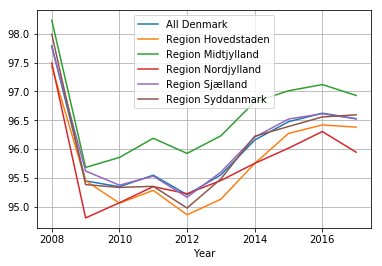

In [62]:
JoinTotal.set_index('Year').groupby('Region')['Employ_share'].plot(legend=True, grid=True)